In [1]:
from fenics import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
from egfcore import *
from utils import *

set_log_level(30)
%matplotlib widget

In [2]:
class Simulator:
    
    def __init__(self, meshDensity):
        self.mesh = IntervalMesh(meshDensity,0,1) # (meshDensity = N_sensors) =  # of positions at which the problem is discretized on a unit interval
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh.mat", mesh_dict)
        self.V = FunctionSpace(self.mesh, 'P', 2)
        
        # Define the function space and store the meshweights for computation.
        V = FunctionSpace(self.mesh,'P',1)
        u = TestFunction(V)
        temp = assemble(u*dx)
        self.meshweights = (temp.get_local()[vertex_to_dof_map(V)]).reshape(-1,1)
        
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh2D.mat", mesh_dict)
        
        # Create variational form for the problem
        self.bc = self.boundaryConditions()
        u = TrialFunction(self.V)
        v = TestFunction(self.V)
        self.f = Function(V)
        self.param = Constant(0)
        self.d2v = dof_to_vertex_map(V)
        self.a = dot(grad(u), grad(v))* dx
        self.L = self.f*v*dx
        self.u = Function(self.V)
        
    def boundaryConditions(self):
        """
        Define homogeneous Dirichlet Boundary conditions for the problem.
        """
        def boundary(x, on_boundary):
            return on_boundary
        
        u_D = Constant(0)
        bc = DirichletBC(self.V, u_D, boundary)
        
        return bc
    
    def solve(self, forcing, noise_level = None, param=None):
        """
        Given a (N_sensors x 1) forcing vector, solve the a 1D Poisson problem on a unit interval.
        """
        
        self.f.vector()[:] = forcing[self.d2v] # Instantiate the source term in the variational form by interpolating the sampled sourcing term.
        if param is not None:
            self.param.assign(param) # Define the parameter for the problem
        solve(self.a == self.L, self.u, self.bc) # Solve the variation form

        # Sample the solution at the nodes of the mesh.
        solution = self.u.compute_vertex_values(self.mesh)
        
        # As specified, add IID Gaussian white noise.
        if noise_level is not None:
            noise =  noise_level*np.random.normal(0,np.abs(solution.mean()),solution.shape)
            solution += noise
        
        return solution

In [3]:
def exactGreen(domain, param):
    x, s = np.meshgrid(domain,domain)
    G = np.empty(np.shape(x))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            xx, ss = x[i,j], s[i,j]
            if xx <= ss:
                G[i,j] = xx * (1-ss)
            else:
                G[i,j] = ss * (1-xx)
    return G

In [4]:
%%time
params = np.array([0])
add_noise = False
noise_level = 0.1
verbose = False

meshDensity = 2000
sigma = 0.005
nSamples = 2000
rank = 100

print(f"Method: Coefficient fit | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")
Sim = Simulator(meshDensity)

meshweights = Sim.meshweights

forcing = sampleforcing(sigma, nSamples)
solution = np.zeros(forcing.shape)
for i in range(solution.shape[1]):
    if verbose:
        print("i = %d / %d"%(i+1, solution.shape[1]))
    if add_noise:
        solution[:,i] = Sim.solve(forcing[:,i], noise_level)
    else:
        solution[:,i] = Sim.solve(forcing[:,i])
        
model = EGF("coefficient-fit", params, rank, Sim.mesh, forcing, solution, None, None, None, None, verbose = verbose)

G_reconstruction = reconstructEGF1D(model)
G = exactGreen(model.mesh.coordinates(), model.params[0])
error = computeError(G_reconstruction, G)

Method: Coefficient fit | meshDensity: 2000, sigma: 0.005, nSamples: 2000, rank: 100, Noise: False
CPU times: user 8min 53s, sys: 2min 54s, total: 11min 48s
Wall time: 9min 25s


0.00833377572452661


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
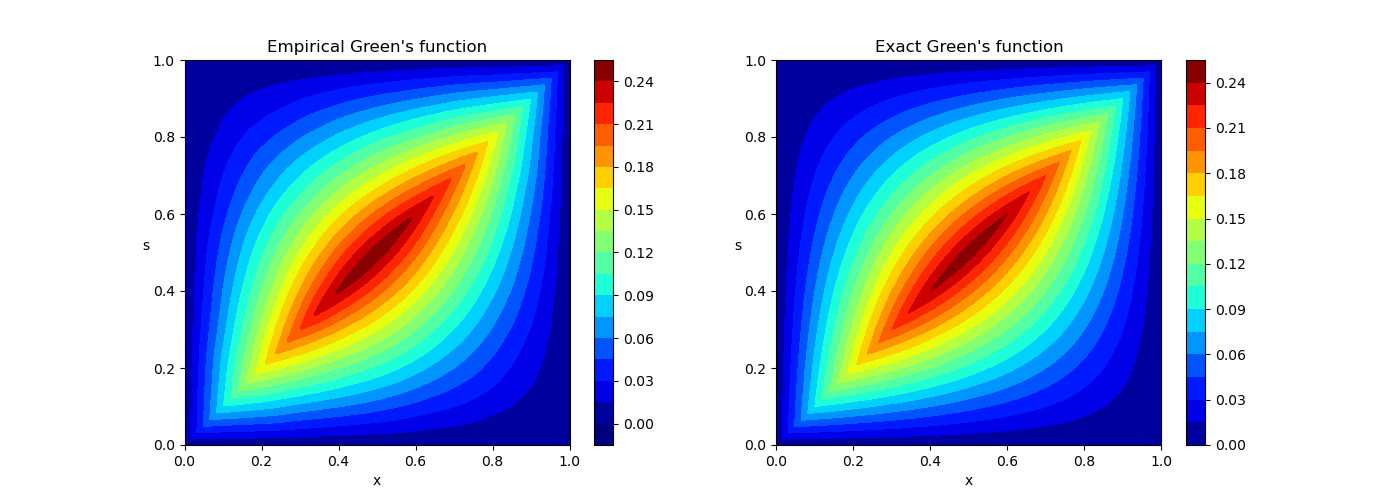

In [5]:
compareGreen1D(model, exactGreen, 0, 0.25)
print(error)

Text(0.5, 0, 'x')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
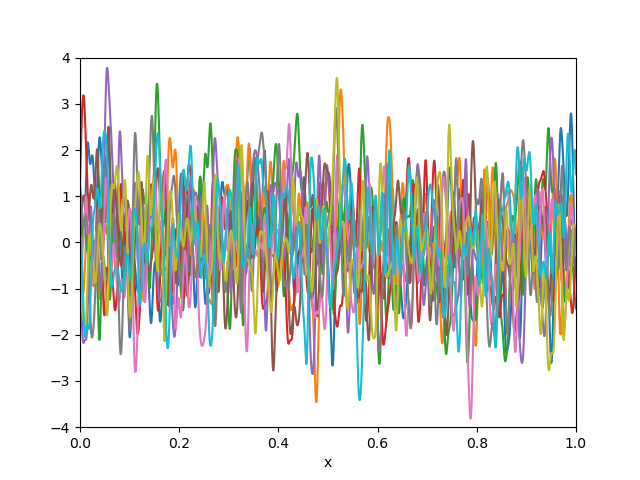

In [6]:
# Print random forcing functions
plt.figure()
x = np.linspace(0,1,model.forcing.shape[0])
plt.plot(x,model.forcing[:,:10])
plt.ylim([-4,4])
plt.xlim([0,1])
plt.xlabel('x')

Text(0.5, 0, 'x')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
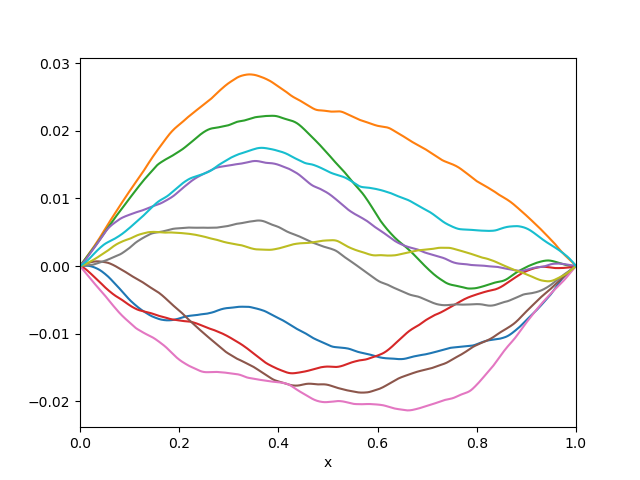

In [7]:
# Print corresponding resopnses
plt.figure()
x = np.linspace(0,1,model.signal.shape[0])
plt.plot(x,model.signal[:,:10])
# plt.ylim([-0.03,0.03])
plt.xlim([0,1])
plt.xlabel('x')

In [8]:
samples = 100 # Compute empirical error for 100 samples but on the same mesh

if add_noise:
    empError = computeEmpiricalError(model, Sim, sigma, samples, noise_level)
else:
    empError = computeEmpiricalError(model, Sim, sigma, samples)

print(f"Max error: {np.max(empError)}")
print(f"Mean error: {np.mean(empError)}")

Max error: 0.041026531774677966
Mean error: 0.01603695254277351


In [9]:
%%time
params = np.array([0])
add_noise = False
noise_level = 0.1
verbose = False

meshDensity = 2000
sigma = 0.005
rank = 100
nSamples = rank

np.random.seed(42)
    
print(f"Method: Randomized SVD | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")
Sim = Simulator(meshDensity)

meshweights = Sim.meshweights

# Generate an forcing and output ensemble by simulating Poisson problem with FENICS.
forcing = sampleforcing(sigma, nSamples)
solution = np.zeros(forcing.shape)
for i in range(solution.shape[1]):
    if verbose:
        print("i = %d / %d"%(i+1, solution.shape[1]))
    if add_noise:
        solution[:,i] = Sim.solve(forcing[:,i], noise_level)
    else:
        solution[:,i] = Sim.solve(forcing[:,i])

if add_noise:
    modelrandomized = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, noise_level, None, None, Sim, verbose = verbose)
else:
    modelrandomized = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, None, None, None, Sim, verbose = verbose)

G_reconstruction = reconstructEGF1D(modelrandomized)
G = exactGreen(modelrandomized.mesh.coordinates(), modelrandomized.params[0])
error = computeError(G_reconstruction, G)

Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False
CPU times: user 24 s, sys: 3.64 s, total: 27.7 s
Wall time: 36.8 s


0.0002748231810456085


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
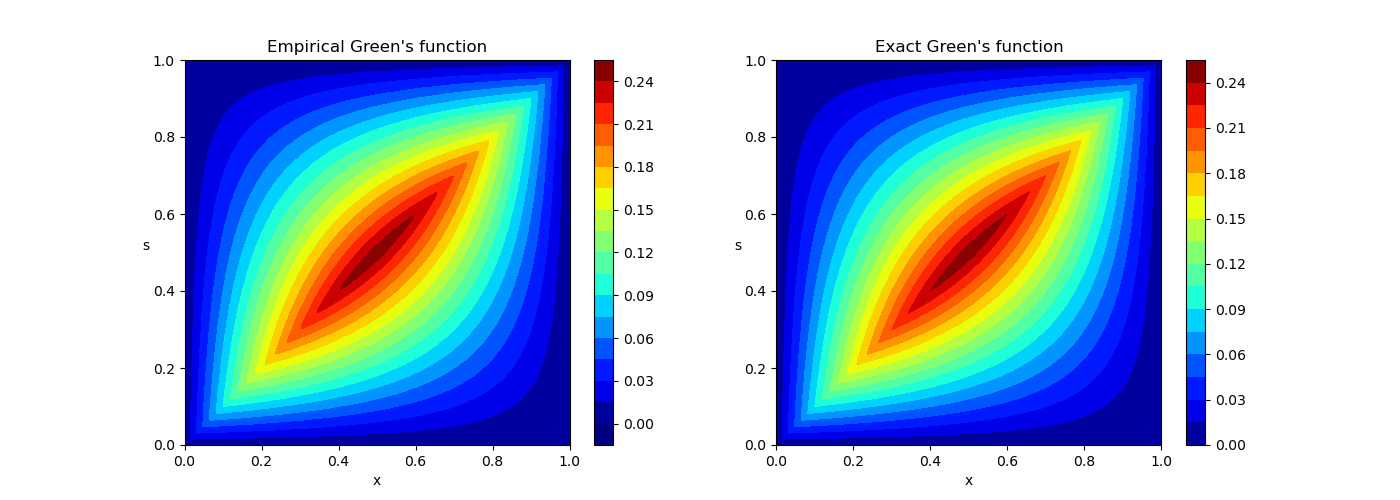

In [10]:
compareGreen1D(modelrandomized, exactGreen, 0, 0.25)
print(error)

In [11]:
samples = 100 # Compute empirical error for 100 samples but on the same mesh

if add_noise:
    empError = computeEmpiricalError(modelrandomized, Sim, sigma, samples, noise_level)
else:
    empError = computeEmpiricalError(modelrandomized, Sim, sigma, samples)

print(f"Max error: {np.max(empError)}")
print(f"Mean error: {np.mean(empError)}")

Max error: 0.006577021092359263
Mean error: 0.0012658218327091725


In [12]:
def compareGreenpaper(model1, model2, exactGreen, vmin = None, vmax = None):
    domain = model1.mesh.coordinates()
    x, s = np.meshgrid(domain,domain)
    fig = plt.figure(figsize = (13,10))
    
    plt.tight_layout()
    plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)
    plt.subplot(221)

    G = exactGreen(domain, model.params[0])
    
    plt.gca().set_aspect('equal', adjustable='box')
    surf = plt.contourf(x, s, G, 20, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.colorbar(surf,fraction=0.046, pad=0.04)
    plt.clim(vmin, vmax)
    plt.xlabel('x')
    plt.ylabel('s', rotation='horizontal', labelpad=15)
    plt.title("Exact Green's function")
    plt.title('A',loc ='left', weight = 'bold', size = 12)
    
    plt.subplot(222)
    
    G_reconstruction = reconstructEGF1D(model1)
    
    surf = plt.contourf(x, s, G_reconstruction, 20, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(surf,fraction=0.046, pad=0.04)
    plt.clim(vmin, vmax) 
    plt.xlabel('x')
    plt.ylabel('s', rotation='horizontal', labelpad=15)
    plt.title("Coefficient Fit")
    plt.title('B',loc ='left', weight = 'bold', size = 12)
    
    plt.subplot(223)
    
    G_reconstruction = reconstructEGF1D(model2)
    
    surf = plt.contourf(x, s, G_reconstruction, 20, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(surf,fraction=0.046, pad=0.04)
    plt.clim(vmin, vmax)
    plt.xlabel('x')
    plt.ylabel('s', rotation='horizontal', labelpad=15)
    plt.title("Randomized SVD")
    plt.title('C',loc ='left', weight = 'bold', size = 12)
    
    plt.subplot(224)
    
    _, exact_coeffs, _ = np.linalg.svd(np.sqrt(model1.meshweights) * G * np.sqrt(model1.meshweights).T, full_matrices = False)
    exact_coeffs = exact_coeffs[:rank]
    x = np.linspace(1,model.rank, model.rank)
    plt.loglog(x,np.abs(model1.dcoeffs),'gx', alpha = 1)
    plt.loglog(x,np.abs(model2.dcoeffs),'b.', alpha = 1, fillstyle = 'none')
    plt.loglog(x,np.abs(exact_coeffs),'ko', alpha = 1, fillstyle = 'none')
    plt.xlabel('Index of Coefficient/Singular value')
    plt.legend(['Coefficient Fit','Randomized SVD','Exact singular values'])
    plt.title('Comparison of coefficients')
    plt.title('D',loc ='left', weight = 'bold', size = 12)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
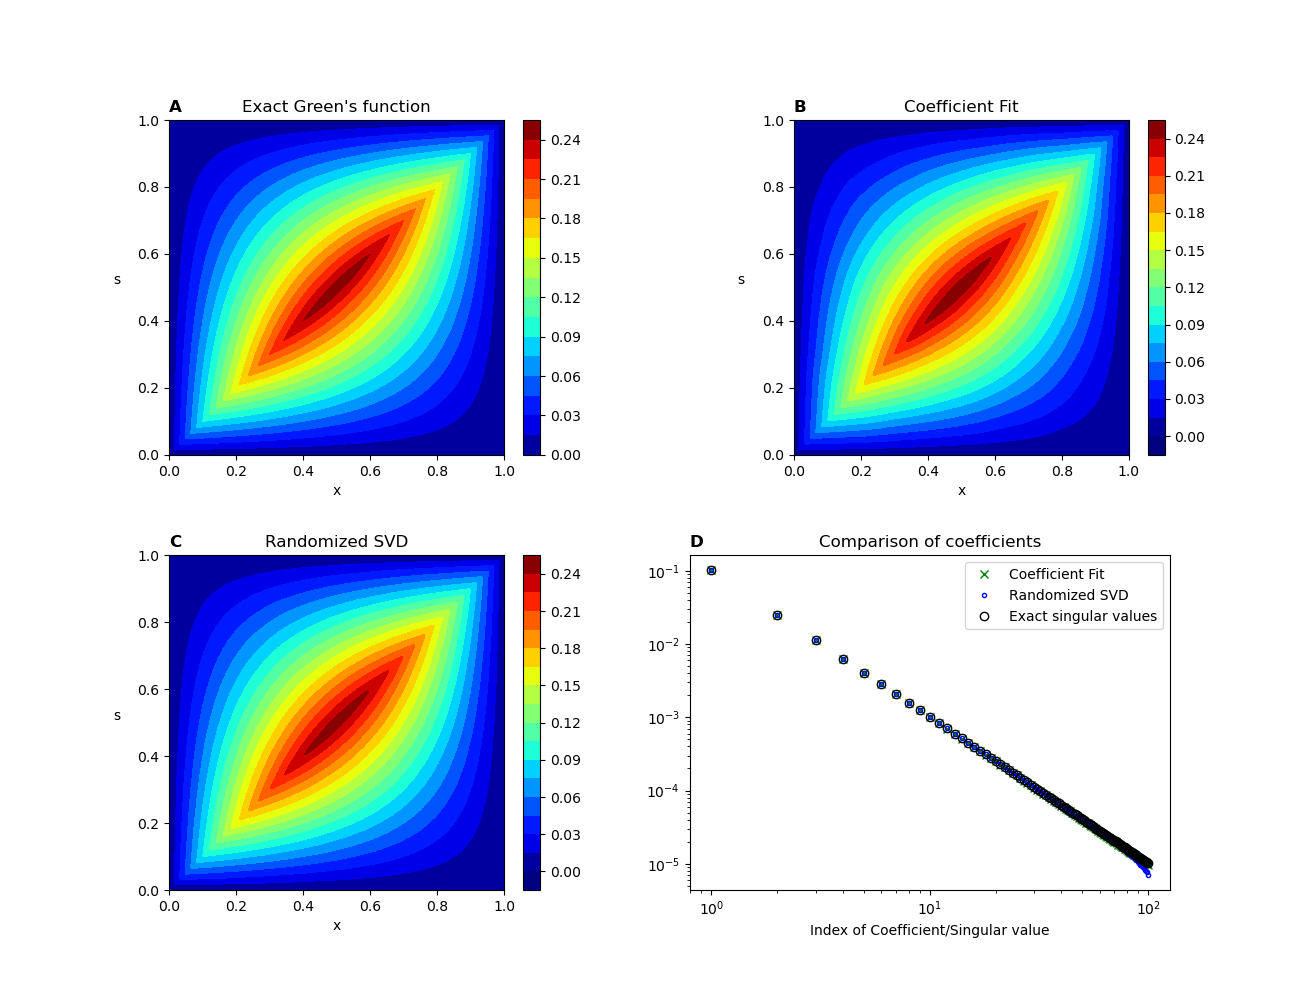

In [13]:
compareGreenpaper(model, modelrandomized, exactGreen, 0, 0.25)